# 1. Setup

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from functools import partial
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest.bayesopt import BayesOptSearch
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.progress_reporter import JupyterNotebookReporter
from ray.air import session
from ray.air.checkpoint import Checkpoint

# Figure settings
from matplotlib import rcParams
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# CUDA settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/var/folders/sc/3ry6kzws7mz6l9dyn8kqhmrh0000gn/T/ipykernel_60789/1777357338.py:15: DeprecationWarning: The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.
  from ray.tune.suggest.bayesopt import BayesOptSearch
/var/folders/sc/3ry6kzws7mz6l9dyn8kqhmrh0000gn/T/ipykernel_60789/1777357338.py:15: DeprecationWarning: The module `ray.tune.suggest.bayesopt` has been moved to `ray.tune.search.bayesopt` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest.bayesopt` with `ray.tune.search.bayesopt`.
  from ray.tune.suggest.bayesopt import BayesOptSearch
/var/folders/sc/3ry6kzws7mz6l9dyn8kqhmrh0000gn/T/ipykernel_60789/1777357338.py:16: DeprecationWarning: The module `ray.tune.suggest.hyperopt` ha

# 2. Importing Data

In [2]:
# Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

# Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

# 3. Exploratory Data Analysis

## 3.1 Brain Region Analysis

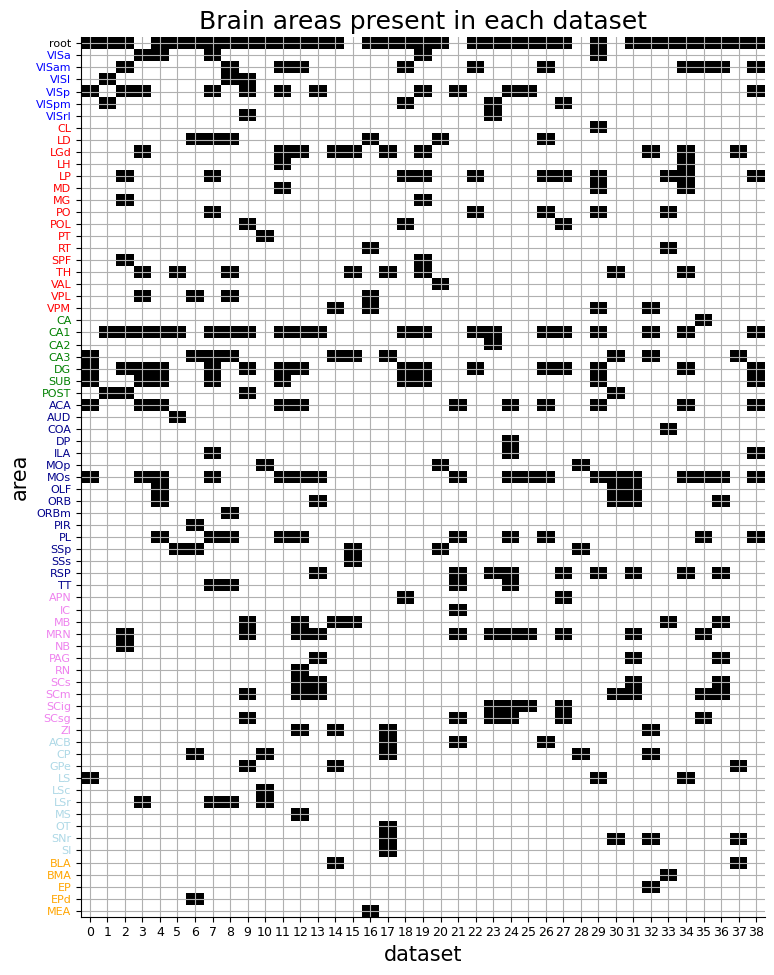

In [3]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

def sort_groups (brain_area):
  for index, group in enumerate(brain_groups):
    for i in group:
      if brain_area == i:
        return regions[index]
  return regions[-1]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

## 3.2 Pairwise plot of pupil (LHS) and firing rate (RHS)

In [4]:
# Session 12 is selected because of eye-relevant SC (midbrain) and LGd (thalamus) data
session_12 = alldat[12]
data = np.array(session_12['pupil'])

# x-axis values: range of 250 time points * 10ms
x = np.array(range(data.shape[2])) * 10 / 1000

# Constants
dt = 10 / 1000  # convert timebins to seconds
NT = session_12['spks'].shape[-1]
regions_of_interest = ['SCs', 'SCm', 'LGd']

# Get neuron indices for each region of interest
neuron_indices = {region: np.where(session_12['brain_area'] == region)[0] for region in regions_of_interest}

# # Iterate through trials
# for trial in range(session_12['spks'].shape[1]):
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
#     # Pupil plot
#     for dim, label in zip(range(data.shape[0]), ['Pupil size', 'Horizontal pos', 'Vertical pos']):
#         axs[0].plot(x, data[dim, trial, :], label=label)

#     axs[0].legend()
#     axs[0].set_xlabel('Time (s)')
#     axs[0].set_ylabel('Values')
#     axs[0].set_title(f'Trial {trial + 1} - Pupil')

#     # Firing rate plot
#     for region, indices in neuron_indices.items():
#         # Select spikes for neurons in this region and this trial, compute mean spiking rate (in Hz)
#         mean_spiking_rate = session_12['spks'][indices, trial].mean(axis=0) / dt
#         axs[1].plot(np.arange(NT) * dt, mean_spiking_rate, label=region)

#     axs[1].set_xlabel('Time (s)')
#     axs[1].set_ylabel('Mean Spiking Rate (Hz)')
#     axs[1].set_title(f'Trial {trial + 1} - Firing Rate')
#     axs[1].legend()
    
#     plt.tight_layout()
#     plt.show()


# 4. Data Preparation

In [5]:
# Constants
regions_of_interest = ['SCs', 'SCm', 'LGd']
num_trials = session_12['spks'].shape[1]
num_timebins = session_12['spks'].shape[2]
num_regions = len(regions_of_interest)

# Initialize arrays for X and y
X = np.zeros((num_trials, 3, num_timebins))  # pupil data
y = np.zeros((num_trials, num_regions, num_timebins))  # average neural activity

# Populate X array with pupil data. X shape is (trial_number, pupil_data_type, timebin)
X[:, 0, :] = session_12['pupil'][0]  # pupil size
X[:, 1, :] = session_12['pupil'][1]  # horizontal position
X[:, 2, :] = session_12['pupil'][2]  # vertical position

# Compute neural firing rates for each region and each trial
for i, region in enumerate(regions_of_interest):
    neuron_indices = np.where(session_12['brain_area'] == region)[0]
    for trial in range(num_trials):
        y[trial, i, :] = session_12['spks'][neuron_indices, trial].mean(axis=0)
        y[trial, i, :] = np.convolve(y[trial, i, :], np.ones(10) / 10, mode='full')[:250]

# Use 80% of data for training and 20% for validation
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors and reshape to match the expected input shape for RNN (seq_len, batch, input_size)
X_train = torch.from_numpy(X_train).permute(2, 0, 1)
y_train = torch.from_numpy(y_train).permute(2, 0, 1)
X_cv = torch.from_numpy(X_cv).permute(2, 0, 1)
y_cv = torch.from_numpy(y_cv).permute(2, 0, 1)

# 5. Define RNN Class

In [6]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, bidi=True):
        super(Net, self).__init__()
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                          bidirectional = bidi, nonlinearity = 'tanh')
        self.fc = nn.Linear(ncomp, NN2)
        self.ncomp = ncomp

    def forward(self, x):
        y = self.rnn(x)[0]
        if self.rnn.bidirectional:
            q = (y[:, :, :self.ncomp] + y[:, :, self.ncomp:])/2
        else:
            q = y
        z = F.softplus(self.fc(q), 10)
        # z = self.fc(q)
        return z, q

# 6. Define Training Function

In [7]:
# Convert data to double precision
from functools import lru_cache


X_train = X_train.double()
y_train = y_train.double()
X_cv = X_cv.double()
y_cv = y_cv.double()

# Define optimizer and loss function
niter = 200
patience = 25 # Patience parameter for early stopping regularization
best_loss = np.inf
no_improvement_iters = 0 # Initialize counter to track how many iters there is no improvement in loss

# implements above into train_model function for use during hyperparameter optimization in Ray Tune
def train_model(config, X_train, y_train, X_cv, y_cv, NN1, NN2, checkpoint_dir=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ncomp = int(config["ncomp"])
    net = Net(ncomp, NN1, NN2).double().to(device)

    # Define optimizer and loss function
    optimizer = Adam(net.parameters(), weight_decay = wd, lr = lr)
    
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_cv, y_cv = X_cv.to(device), y_cv.to(device)

    # Training loop
    niter = 200
    patience = 25 # Patience parameter for early stopping regularization
    best_loss = np.inf
    no_improvement_iters = 0 # Initialize counter to track how many iters there is no improvement in loss

    for k in range(niter):
        # Forward pass: compute predicted y by passing x to the model
        y_pred, _ = net(X_train)

        # Compute loss
        loss = loss_fn(y_pred, y_train).mean()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Zero gradients
        optimizer.zero_grad()

        # Evaluate loss on CV set for early stopping (should this be on CV set or training set in principle? I feel like using CV set is cheating)
        y_cv_pred, _ = net(X_cv)
        cv_loss = loss_fn(y_cv_pred, y_cv).mean()

        # Check if validation loss has improved
        if cv_loss < best_loss:
            best_loss = cv_loss
            no_improvement_iters = 0  # Reset counter
        else:
            no_improvement_iters += 1
        
        if no_improvement_iters >= patience: # Triggering early stopping if no improvement after patience threshold exceeded
            print(f'Early stopping on iteration {k}, best loss was {best_loss.item():.4f}')
            break

        # for Ray Tune: reports loss back to Ray Tune
        tune.report(loss=(cv_loss.item()))
    
    # Save checkpoint
    if checkpoint_dir:
        path = os.path.join(checkpoint_dir, "checkpoint")
        torch.save(net.state_dict(), path)
    
    return net

# 7. Baseline Model

## 7.1 Baseline Training

In [8]:
# Initialize baseline RNN hyperparameters
ncomp = 27  # number of hidden units
NN1 = 3  # input size
NN2 = num_regions  # output size
net = Net(ncomp, NN1, NN2)
net = net.double()  # Ensure model parameters are in double precision
wd = 0
lr = 0.001
loss_fn = nn.MSELoss()
optimizer = Adam(net.parameters(), weight_decay=wd, lr=lr)

for k in range(niter):
    # Forward pass: compute predicted y by passing x to the model
    y_pred, _ = net(X_train)

    # Compute loss
    loss = loss_fn(y_pred, y_train).mean()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Perform a single optimization step (parameter update)
    optimizer.step()

    # Zero gradients
    optimizer.zero_grad()

    # Evaluate loss on CV set for early stopping (should this be on CV set or training set in principle? I feel like using CV set is cheating)
    y_cv_pred, _ = net(X_cv)
    cv_loss = loss_fn(y_cv_pred, y_cv).mean()

    # Check if validation loss has improved
    if cv_loss < best_loss:
        best_loss = cv_loss
        no_improvement_iters = 0  # Reset counter
    else:
        no_improvement_iters += 1
    
    if no_improvement_iters >= patience: # Triggering early stopping if no improvement after patience threshold exceeded
        print(f'Early stopping on iteration {k}, best loss was {best_loss.item():.8f}')
        break

    # Print progress
    if k % 50 == 0:
        print(f'iteration {k}, loss {loss.item():.8f}')

iteration 0, loss 0.00542045
iteration 50, loss 0.00045379
iteration 100, loss 0.00044357
iteration 150, loss 0.00043786


## 7.2 Baseline Cross Validation

In [9]:
# Initialize variables to store the cross-validation results
cv_losses = []

# Initialize a variable to store the cross-validation predictions
y_cv_pred = []

# Loop over the cross-validation data
for i in range(X_cv.shape[1]):

    # Get the data for the current batch
    x_batch = X_cv[:, i:i+1, :]
    y_batch = y_cv[:, i:i+1, :]

    # Compute the network's output for the current batch
    y_pred, _ = net(x_batch)

    # Compute the loss for the current batch
    loss = loss_fn(y_pred, y_batch).mean()

    # Store the predictions
    y_cv_pred.append(y_pred.detach().numpy())

    # Store the loss
    cv_losses.append(loss.item())

# Compute the average cross-validation loss
cv_loss = np.mean(cv_losses)

print(f'Cross-validation loss: {cv_loss:.8f}')

Cross-validation loss: 0.00041308


## 7.3 Baseline Performance Summary

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Creating model summary
print("Model Summary:")
for name, param in net.named_parameters():
    print(f'Layer: {name}  | Size: {param.size()}')

# Training score
train_losses = []

for i in range(X_train.shape[1]):
    x_batch = X_train[:, i:i+1, :]
    y_batch = y_train[:, i:i+1, :]

    y_pred, _ = net(x_batch)
    loss = loss_fn(y_pred, y_batch).mean()

    train_losses.append(loss.item())

train_loss = np.mean(train_losses)

print(f'The model has {count_parameters(net):,} trainable parameters')
print(f'Train loss: {train_loss:.8f}')

# Cross-validation score
print(f'Cross-validation loss: {cv_loss:.8f}')

Model Summary:
Layer: rnn.weight_ih_l0  | Size: torch.Size([27, 3])
Layer: rnn.weight_hh_l0  | Size: torch.Size([27, 27])
Layer: rnn.bias_ih_l0  | Size: torch.Size([27])
Layer: rnn.bias_hh_l0  | Size: torch.Size([27])
Layer: rnn.weight_ih_l0_reverse  | Size: torch.Size([27, 3])
Layer: rnn.weight_hh_l0_reverse  | Size: torch.Size([27, 27])
Layer: rnn.bias_ih_l0_reverse  | Size: torch.Size([27])
Layer: rnn.bias_hh_l0_reverse  | Size: torch.Size([27])
Layer: fc.weight  | Size: torch.Size([3, 27])
Layer: fc.bias  | Size: torch.Size([3])
The model has 1,812 trainable parameters
Train loss: 0.00043300
Cross-validation loss: 0.00041308


## 7.4 Baseline CV Performance Plots

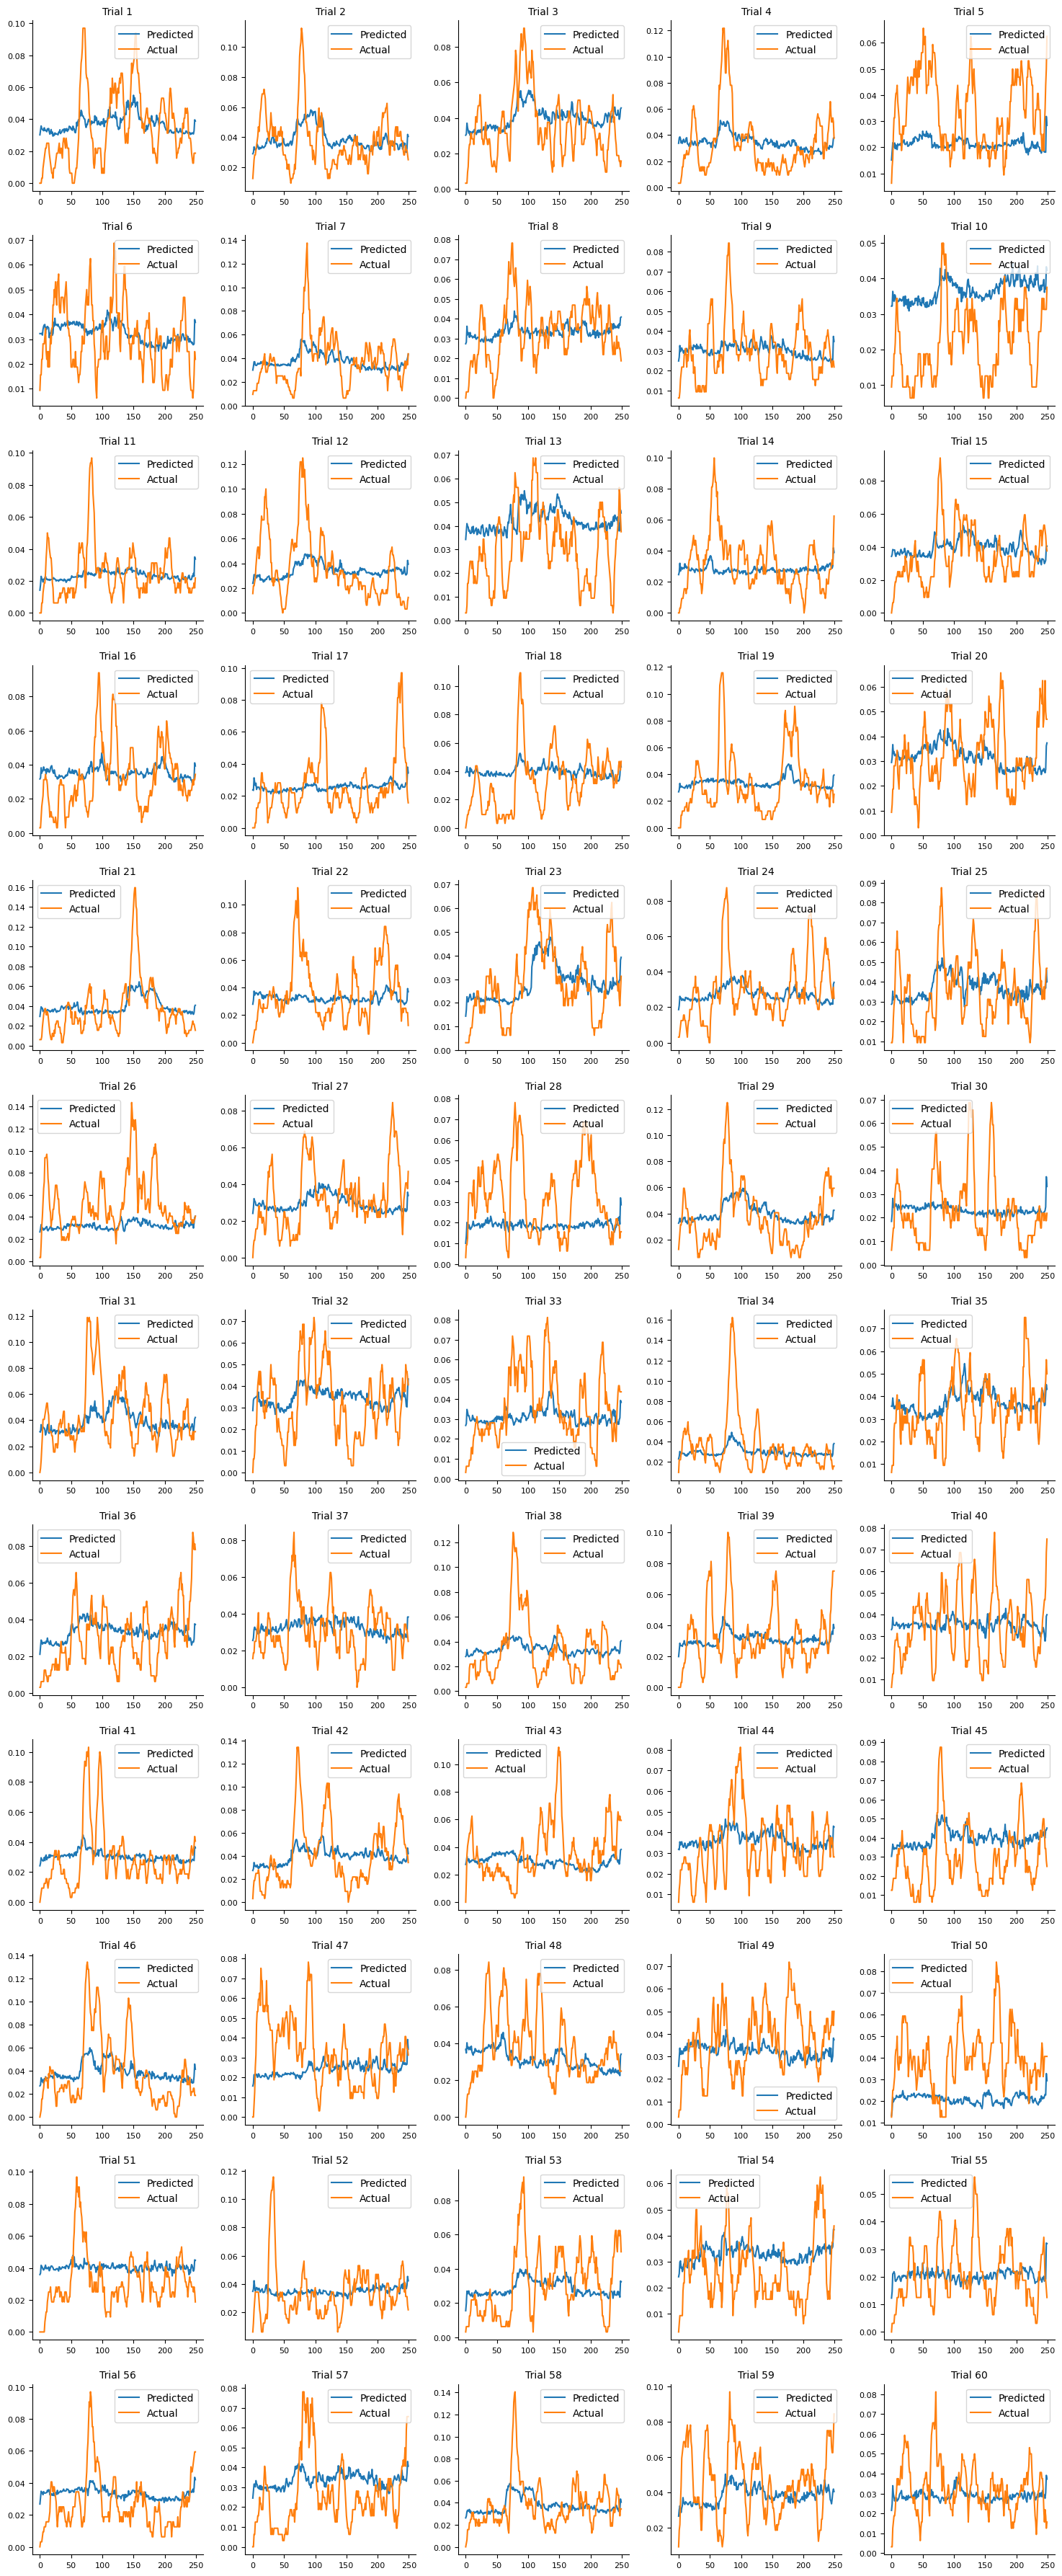

In [11]:
# Select data
selection = 0  # 0 for 'SCs', 1 for 'SCm', 2 for 'LGd'

# Select specified data
y_cv_pred = np.array(y_cv_pred)
y_cv_pred_selected = y_cv_pred[..., selection]
y_cv_selected = y_cv[..., selection]

# Permute y_cv_selected to match dimensions of y_cv_pred_selected
y_cv_selected = y_cv_selected.permute(1, 0)

# Calculate number of plots
num_plots = y_cv_selected.shape[0]

# Calculate number of rows needed
num_rows = num_plots // 5 if num_plots % 5 == 0 else num_plots // 5 + 1

# Create subplots for each trial
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))

for i in range(num_plots):
    row = i // 5
    col = i % 5
    axs[row, col].plot(y_cv_pred_selected[i, :], label='Predicted')
    axs[row, col].plot(y_cv_selected[i, :], label='Actual')
    axs[row, col].set_title(f'Trial {i+1}', fontsize=10)
    axs[row, col].legend(fontsize=10)
    axs[row, col].tick_params(axis='both', which='major', labelsize=8)

# Hide any unused subplots
for j in range(num_plots, num_rows * 5):
    axs[j // 5, j % 5].axis('off')

plt.tight_layout()
plt.show()


# 8. Hyperparameter Optimization

### 8.1 HyperOpt

In [12]:
def tune_model(X_train, y_train, X_cv, y_cv):
    config = {
        "ncomp": tune.choice([10, 20, 30, 40, 50, 60]),
        "wd": tune.loguniform(1e-4, 1e-1),
        "lr": tune.loguniform(1e-4, 1e-1)
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=100,
        grace_period=1,
        reduction_factor=2
    )

    reporter = JupyterNotebookReporter(
        overwrite=True,
        metric_columns=["loss", "training_iteration"],
        parameter_columns=["ncomp", "wd", "lr"],
        max_progress_rows=30,
        max_error_rows=5,
        max_report_frequency=5
    )

    hyperopt_search = HyperOptSearch(metric="loss", mode="min")

    result = tune.run(
        partial(train_model, X_train=X_train, y_train=y_train, X_cv=X_cv, y_cv=y_cv, NN1=NN1, NN2=NN2),
        resources_per_trial={"cpu": 1, "gpu": 0},
        config=config,
        num_samples=10,
        scheduler=scheduler,
        search_alg=hyperopt_search,
        progress_reporter=reporter
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))

    return result, best_trial.config

result, best_config = tune_model(X_train, y_train, X_cv, y_cv)

2023-07-21 10:01:33,134	ERROR services.py:1169 -- Failed to start the dashboard , return code 0
2023-07-21 10:01:33,135	ERROR services.py:1194 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/ray-logging.html#logging-directory-structure' to find where the log file is.
2023-07-21 10:01:33,139	ERROR services.py:1238 -- 
The last 20 lines of /tmp/ray/session_2023-07-21_10-01-31_318348_60789/logs/dashboard.log (it contains the error message from the dashboard): 
    loop.run_until_complete(dashboard.run())
  File "/Users/williamyang/anaconda3/lib/python3.10/asyncio/base_events.py", line 649, in run_until_complete
    return future.result()
  File "/Users/williamyang/anaconda3/lib/python3.10/site-packages/ray/dashboard/dashboard.py", line 70, in run
    await self.dashboard_head.run()
  File "/Users/williamyang/anaconda3/lib/python3.10/site-packages/ray/dashboard/head.py", line 3

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_1d31c62b,2023-07-21_10-01-47,True,,ecea6b84df1641bb9835f0c8426e5008,Williams-MacBook-Air-2.local,4,0.00063557,127.0.0.1,60843,4.27704,0.862718,4.27704,1689930107,0,,4,1d31c62b,0.00673103
train_model_2449ad1c,2023-07-21_10-01-41,True,,482dac5056c64888897763a4694e46bc,Williams-MacBook-Air-2.local,1,0.00640779,127.0.0.1,60840,0.615636,0.615636,0.615636,1689930101,0,,1,2449ad1c,0.00926709
train_model_35262723,2023-07-21_10-01-51,True,,190948feb7d54b31ad13639cd8f12d0c,Williams-MacBook-Air-2.local,16,0.000607161,127.0.0.1,60846,8.27929,0.425763,8.27929,1689930111,0,,16,35262723,0.00639701
train_model_4578bcf5,2023-07-21_10-01-43,True,,7692fc4d7ec64a92bee7293fdb3f47de,Williams-MacBook-Air-2.local,1,0.0341594,127.0.0.1,60848,0.279595,0.279595,0.279595,1689930103,0,,1,4578bcf5,0.0040009
train_model_59b40758,2023-07-21_10-01-48,True,,f4f65ad65f5940a1b1c7a7adf5b6aed3,Williams-MacBook-Air-2.local,16,0.000663588,127.0.0.1,60837,11.3226,0.297829,11.3226,1689930108,0,,16,59b40758,0.00218081
train_model_84713be3,2023-07-21_10-01-44,True,,7692fc4d7ec64a92bee7293fdb3f47de,Williams-MacBook-Air-2.local,1,0.0158971,127.0.0.1,60848,0.842934,0.842934,0.842934,1689930104,0,,1,84713be3,0.0040009
train_model_8cf751f8,2023-07-21_10-01-59,True,,e36a2cc603244298b03204745f2ee076,Williams-MacBook-Air-2.local,100,0.00040562,127.0.0.1,60844,16.6369,0.137933,16.6369,1689930119,0,,100,8cf751f8,0.00736618
train_model_abf222af,2023-07-21_10-01-45,True,,482dac5056c64888897763a4694e46bc,Williams-MacBook-Air-2.local,1,0.00695547,127.0.0.1,60840,1.83139,1.83139,1.83139,1689930105,0,,1,abf222af,0.00926709
train_model_e8b6c01c,2023-07-21_10-02-13,True,,365e7d069ed747cca4f24db4e1c8b26d,Williams-MacBook-Air-2.local,100,0.000390669,127.0.0.1,60841,31.9458,0.235291,31.9458,1689930133,0,,100,e8b6c01c,0.00623894
train_model_f69e961a,2023-07-21_10-02-16,True,,98d0e85d6ed7446a8547b388efa0bc15,Williams-MacBook-Air-2.local,100,0.000377168,127.0.0.1,60842,35.0879,0.218352,35.0879,1689930136,0,,100,f69e961a,0.0113869


2023-07-21 10:02:16,544	INFO tune.py:798 -- Total run time: 41.66 seconds (41.60 seconds for the tuning loop).


Best trial config: {'ncomp': 60, 'wd': 0.018948729951305254, 'lr': 0.0002813343531487236}
Best trial final validation loss: 0.00037716833644805837


### 8.2 Plotting Performance

2023-07-21 10:02:17,363	WARNING session.py:91 -- Session not detected. You should not be calling `report` outside `tuner.fit()` or while using the class API. 
2023-07-21 10:02:17,363	WARNING session.py:97 --   File "/Users/williamyang/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/williamyang/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/williamyang/anaconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/williamyang/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/williamyang/anaconda3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/Users/williamyang/anaconda3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start

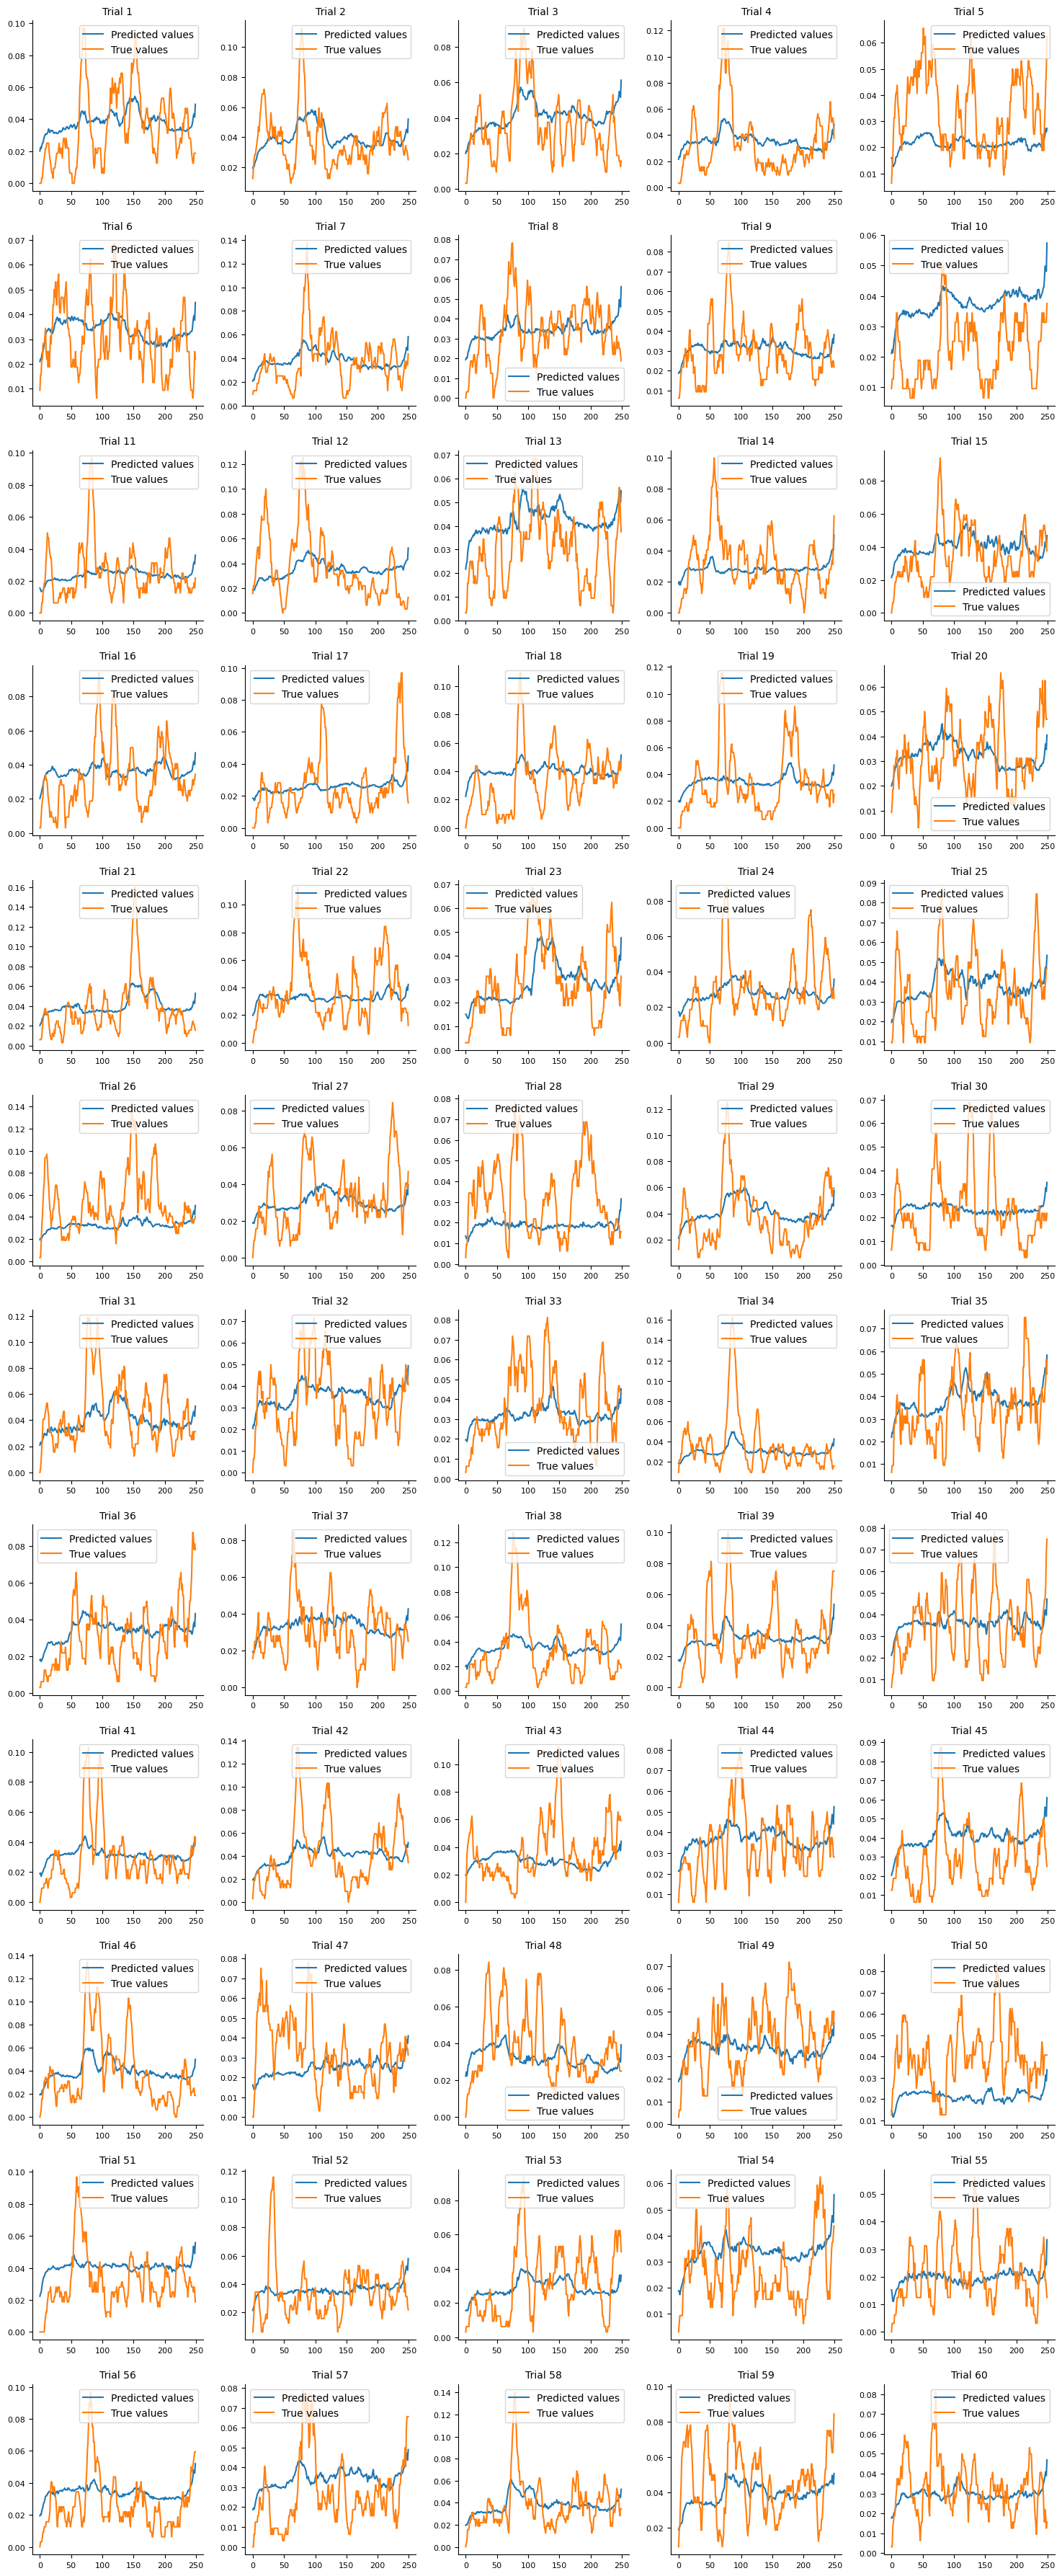

In [13]:
# Load best hyperparameters
ncomp_best = int(best_config["ncomp"])
wd_best = best_config["wd"]
lr_best = best_config["lr"]

# Train model with best hyperparameters
net_best = train_model(best_config, X_train, y_train, X_cv, y_cv, 3, 3)

# Move the best model to the device for prediction
net_best.to(device)

# Generate predictions
y_CV_pred, _ = net_best(X_cv)

# Convert tensors to numpy for plotting
y_cv = y_cv.cpu().detach().numpy()
y_CV_pred = y_CV_pred.cpu().detach().numpy()

# Number of trials (assuming y_cv and y_pred have shape (num_trials, data_points))
num_trials = y_cv.shape[1]

# Selecting which brain region: 0 for 'SCs', 1 for 'SCm', 2 for 'LGd'
selection = 0

# Calculate number of rows needed
num_rows = num_trials // 5 if num_trials % 5 == 0 else num_trials // 5 + 1

# Create subplots for each trial
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))

# Assuming y_CV_pred is reshaped properly
for i in range(num_trials):
    row = i // 5
    col = i % 5
    axs[row, col].plot(y_CV_pred[:, i, selection], label='Predicted values')
    axs[row, col].plot(y_cv[:, i, selection], label='True values')
    axs[row, col].set_title(f'Trial {i+1}', fontsize=10)
    axs[row, col].legend(fontsize=10)
    axs[row, col].tick_params(axis='both', which='major', labelsize=8)

# Hide any unused subplots
for j in range(num_trials, num_rows * 5):
    axs[j // 5, j % 5].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# TODO: Try predicting sum of spikes in each box (or each trial) and use Poisson loss again. Instead of predicting rates. 
# TODO: Do PCA on each region in session 12
## E.g. Take PCA within SCs, take first 3 PCs -> 3*3 = 9 target variables
# TODO: Use Elephant instantaneous rate estimation. Use Gaussian or alpha kernel. 
# TODO: Baseline For Time Series Regression
# TODO: LSTM (?) 
# TODO: Build better performance summary (look for libraries)

# Hyperparameters: 
## ncomp, lr < 0.1 (log scale), wd, ncomp, num_layers (1-2 layers), dropout, bidirectional = bidi, nonlinearity = 'tanh'

# Code Graveyard

In [15]:
# def generate_plots(result, X_cv, y_cv, n_trials=10):
#     # Sort the trials based on the final loss
#     sorted_trials = sorted(result.trials, key=lambda trial: trial.last_result["loss"])
#     best_trials = sorted_trials[:n_trials]

#     for i, trial in enumerate(best_trials):
#         best_net = Net(int(trial.config["ncomp"]), NN1, NN2)  # Initialize the network
#         best_net = best_net.double()
#         best_net.load_state_dict(torch.load(trial.checkpoint.value))  # Load the trained model

#         y_pred, _ = best_net(X_cv)
#         y_pred = y_pred.detach().numpy()
#         y_actual = y_cv.numpy()

#         # Plot actual vs predicted
#         plt.figure(figsize=(10, 6))
#         plt.plot(y_actual, y_pred, 'o', alpha=0.5)
#         plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--')
#         plt.xlabel('Actual')
#         plt.ylabel('Predicted')
#         plt.title(f'Trial {i+1}: Predicted vs Actual')
#         plt.grid(True)
#         plt.show()

# generate_plots(result, X_cv, y_cv)


In [16]:
# def tune_model(X_train, y_train, X_cv, y_cv):
#     config = {
#         "ncomp": tune.choice([10, 20, 30, 40, 50]),
#         "wd": tune.loguniform(1e-4, 1e-1),
#         "lr": tune.loguniform(1e-4, 1e-1)
#     }

#     scheduler = ASHAScheduler(
#         metric="loss",
#         mode="min",
#         max_t=100,
#         grace_period=1,
#         reduction_factor=2)

#     reporter = CLIReporter(
#         metric_columns=["loss", "training_iteration"])

#     result = tune.run(
#         partial(train_model, X_train=X_train, y_train=y_train, X_cv=X_cv, y_cv=y_cv),
#         resources_per_trial={"cpu": 4, "gpu": 0},
#         config=config,
#         num_samples=50,
#         scheduler=scheduler,
#         progress_reporter=reporter)

#     best_trial = result.get_best_trial("loss", "min", "last")
#     print("Best trial config: {}".format(best_trial.config))
#     print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))

# tune_model(X_train, y_train, X_cv, y_cv)